## **APPRENTISSAGE NON SUPERVISÉ BASÉ SUR LES VARIABLES COMMUNES**

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, classification_report
import warnings
from sklearn.compose import ColumnTransformer
warnings.filterwarnings('ignore')


In [39]:
# Import dataset

file = "../DATAS/ANSTAT2021_dataset_Clean.csv"

In [40]:
df = pd.read_csv(file)
df_copy = df.copy()
df_copy

,agro_zone,region_name,department,city,milieu_resid,hhweight,resid,sex,age_num,lien,...,frigo,cuisin,ordin,decod,car,superf,bancarise,volhor_manquant,salaire_mois_manquant,Stg_formel
0,ABIDJAN,AUTONOME D'ABIDJAN,ABIDJAN,ABIDJAN,Urbain,1098.1172,Oui,Féminin,29,"Fils, Fille",...,Oui,Non,Non,Oui,Non,0.0,1,0,0,1
1,ABIDJAN,AUTONOME D'ABIDJAN,ABIDJAN,ABIDJAN,Urbain,1098.1172,Oui,Féminin,17,"Fils, Fille",...,Oui,Non,Non,Oui,Non,0.0,0,1,1,0
2,ABIDJAN,AUTONOME D'ABIDJAN,ABIDJAN,ABIDJAN,Urbain,1098.1172,Oui,Masculin,15,"Fils, Fille",...,Oui,Non,Non,Oui,Non,0.0,0,1,1,0
3,ABIDJAN,AUTONOME D'ABIDJAN,ABIDJAN,ABIDJAN,Urbain,1098.1172,Oui,Féminin,12,"Fils, Fille",...,Oui,Non,Non,Oui,Non,0.0,0,1,1,0
4,ABIDJAN,AUTONOME D'ABIDJAN,ABIDJAN,ABIDJAN,Urbain,1098.1172,Oui,Féminin,34,Conjoint ( e ),...,Oui,Non,Non,Oui,Non,0.0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64469,CENTRE,MORONOU,M'BATTO,TIEMELEKRO,Rural,242.7796,Oui,Masculin,11,Neveu/Nièce,...,Non,Non,Non,Oui,Non,8566398.0,0,1,1,0
64470,CENTRE,MORONOU,M'BATTO,TIEMELEKRO,Rural,242.7796,Oui,Masculin,7,"Fils, Fille",...,Non,Non,Non,Oui,Non,8566398.0,0,1,1,0
64471,CENTRE,MORONOU,M'BATTO,TIEMELEKRO,Rural,242.7796,Oui,Masculin,10,Neveu/Nièce,...,Non,Non,Non,Oui,Non,8566398.0,0,1,1,0
64472,CENTRE,MORONOU,M'BATTO,TIEMELEKRO,Rural,242.7796,Oui,Masculin,4,"Fils, Fille",...,Non,Non,Non,Oui,Non,8566398.0,0,1,1,0


In [41]:
print("📊 Aperçu des données:")
print(df_copy.head())
print(f"\n📈 Forme des données: {df_copy.shape}")
print(f"\n🔍 Valeurs manquantes:\n{df_copy.isnull().sum()}")


📊 Aperçu des données:
  agro_zone         region_name department     city milieu_resid   hhweight  \
0   ABIDJAN  AUTONOME D'ABIDJAN    ABIDJAN  ABIDJAN       Urbain  1098.1172   
1   ABIDJAN  AUTONOME D'ABIDJAN    ABIDJAN  ABIDJAN       Urbain  1098.1172   
2   ABIDJAN  AUTONOME D'ABIDJAN    ABIDJAN  ABIDJAN       Urbain  1098.1172   
3   ABIDJAN  AUTONOME D'ABIDJAN    ABIDJAN  ABIDJAN       Urbain  1098.1172   
4   ABIDJAN  AUTONOME D'ABIDJAN    ABIDJAN  ABIDJAN       Urbain  1098.1172   

  resid       sex  age_num            lien  ... frigo cuisin ordin decod  car  \
0   Oui   Féminin       29     Fils, Fille  ...   Oui    Non   Non   Oui  Non   
1   Oui   Féminin       17     Fils, Fille  ...   Oui    Non   Non   Oui  Non   
2   Oui  Masculin       15     Fils, Fille  ...   Oui    Non   Non   Oui  Non   
3   Oui   Féminin       12     Fils, Fille  ...   Oui    Non   Non   Oui  Non   
4   Oui   Féminin       34  Conjoint ( e )  ...   Oui    Non   Non   Oui  Non   

  superf bancari

In [42]:
# 1. Variables communes
num_vars = ['age_num']
cat_vars = ['sex', 'city', 'marital_status', 'bancarise']

In [43]:
# 2. Préparation pipeline prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_vars),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_vars)
    ])

In [44]:
# 3. Prétraitement des données
X_processed = preprocessor.fit_transform(df_copy)
X_processed

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 322370 stored elements and shape (64474, 453)>

In [45]:
# 4. Recherche du nombre optimal de clusters (k) avec méthode du coude et silhouette score
sse = []
silhouette_scores = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_processed)
    sse.append(kmeans.inertia_)
    
    #silhouette_scores.append(silhouette_score(X_processed, kmeans.labels_))
    score = silhouette_score(X_processed, kmeans.labels_)
    silhouette_scores.append(score)


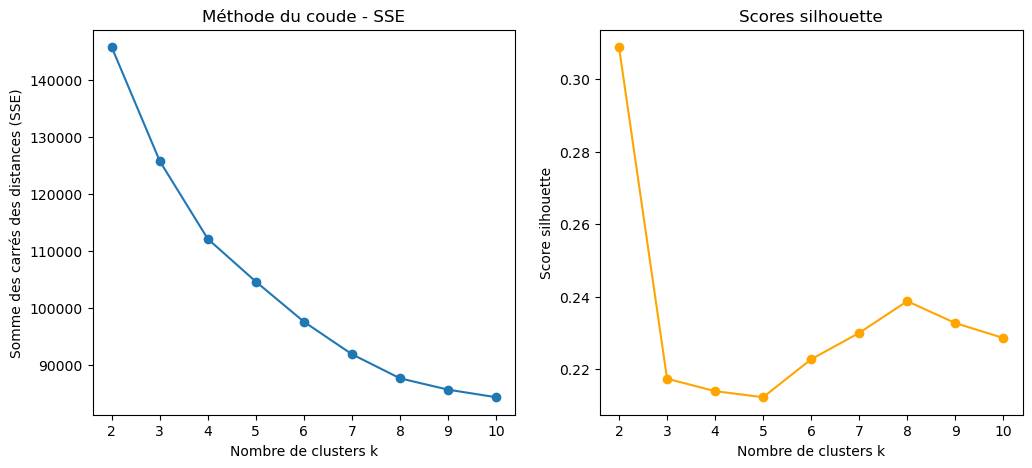

In [46]:
# Affichage méthode du coude
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, sse, marker='o')
plt.title('Méthode du coude - SSE')
plt.xlabel('Nombre de clusters k')
plt.ylabel('Somme des carrés des distances (SSE)')

plt.subplot(1,2,2)
plt.plot(K_range, silhouette_scores, marker='o', color='orange')
plt.title('Scores silhouette')
plt.xlabel('Nombre de clusters k')
plt.ylabel('Score silhouette')

plt.show()

In [51]:
# 5. Choisir k optimal et lancer clustering
k_optimal = 10
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init='auto')
clusters = kmeans_final.fit_predict(X_processed)

In [52]:
# Ajout des clusters au DataFrame
df_copy['cluster'] = clusters

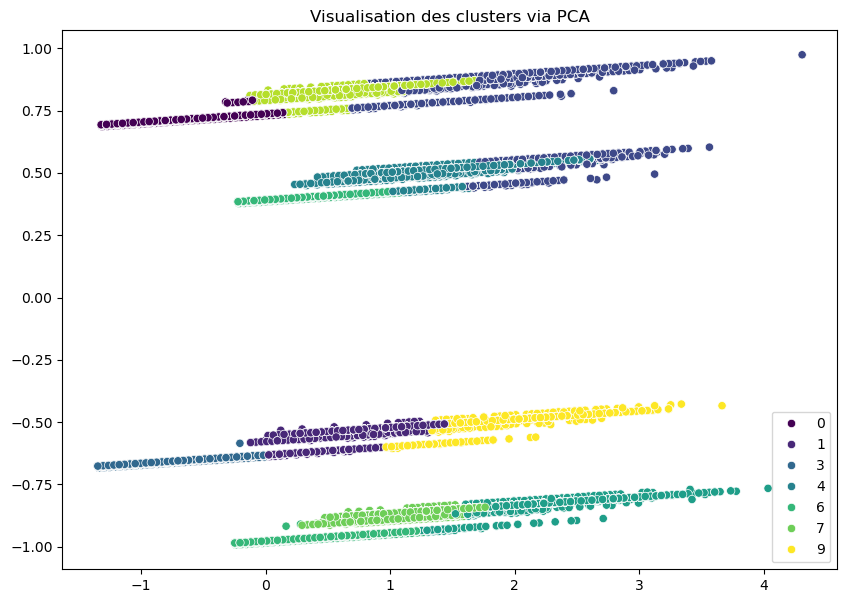

In [53]:
# 6. Réduction dimensionnelle pour visualisation (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed)

plt.figure(figsize=(10,7))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='viridis')
plt.title('Visualisation des clusters via PCA')
plt.show()

In [54]:
# 7. Résumé descriptif par cluster
cluster_summary = df_copy.groupby('cluster')[num_vars + cat_vars].agg(
    {
        'age_num': ['mean', 'median'],
        #'rev_total_mois': ['mean', 'median'],
        'sex': lambda x: x.mode()[0],
        'city': lambda x: x.mode()[0],
        'marital_status': lambda x: x.mode()[0],
        'bancarise': lambda x: x.mode()[0]
    }
)

cluster_summary

age_num              sex     city marital_status bancarise
              mean median  <lambda> <lambda>       <lambda>  <lambda>
cluster                                                              
0         8.761806    8.0   Féminin  ABIDJAN    Célibataire         0
1        37.829373   38.0  Masculin  ABIDJAN       Marié(e)         0
2        64.490566   63.0   Féminin  ABIDJAN       Veuf(ve)         0
3         9.176570    8.0  Masculin  ABIDJAN    Célibataire         0
4        38.542743   38.0   Féminin  ABIDJAN       Marié(e)         1
5        58.384933   57.0  Masculin  ABIDJAN       Marié(e)         1
6        25.101354   23.0  Masculin  ABIDJAN    Célibataire         1
7        36.980343   37.0  Masculin  ABIDJAN       Marié(e)         1
8        34.378460   34.0   Féminin  ABIDJAN       Marié(e)         0
9        64.393064   63.0  Masculin  ABIDJAN       Marié(e)         0